In [1]:
!pip install diffusers transformers accelerate scipy safetensors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.7 MB/s eta 0:00:00


In [1]:
from typing import Any, Callable, Dict, List, Optional, Union

In [2]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-base"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# prompt = "A man is sitting on a park bench"
# image = pipe(prompt).images[0]  


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

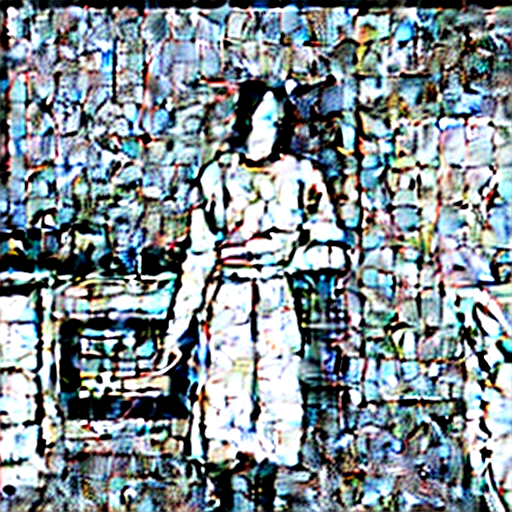

In [139]:
z_image[0]

In [7]:
prompt = "Photograph of woman enters kitchen, in vintage black & white"
negative_prompt = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"
image = pipe(prompt).images[0]  

  0%|          | 0/50 [00:00<?, ?it/s]

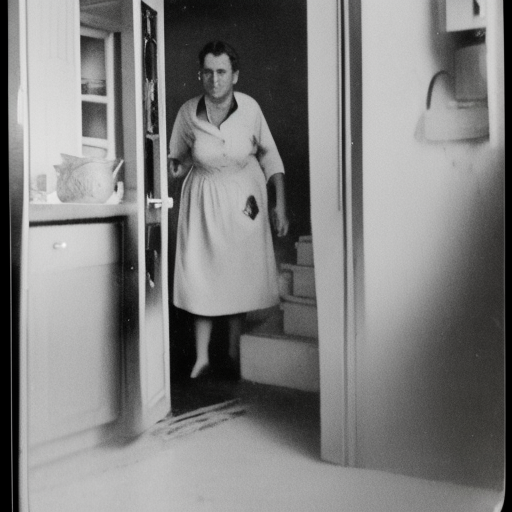

In [8]:
image

In [9]:
prompt = "Photograph of woman opens the refrigerator, in vintage black & white"
negative_prompt = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"
image = pipe(prompt).images[0]  

  0%|          | 0/50 [00:00<?, ?it/s]

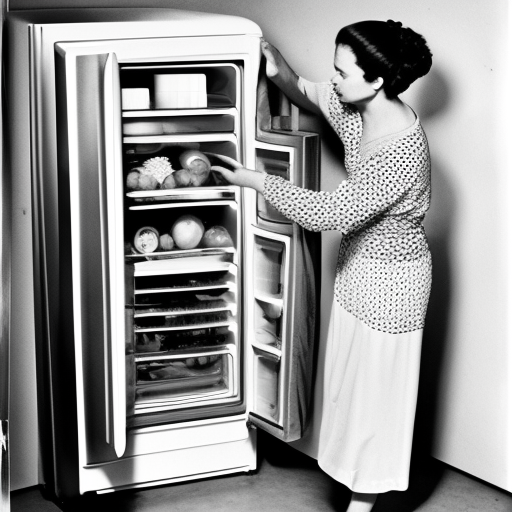

In [10]:
image

In [17]:
prompt = "Photograph of woman takes out a carton of milk, in vintage black & white"
negative_prompt = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"
image = pipe(prompt, negative_prompt=negative_prompt).images[0]  

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
"Photograph of {action}, in vintage black & white"

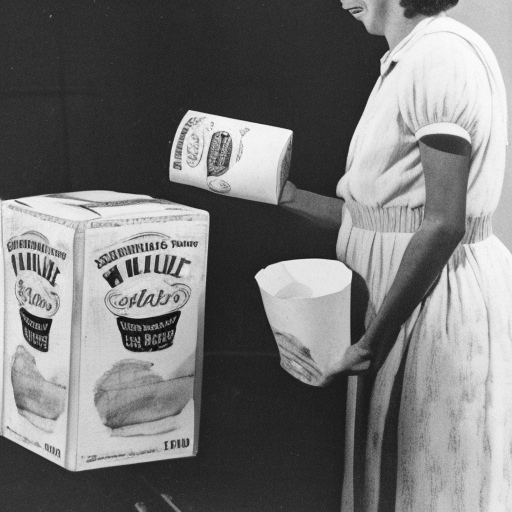

In [12]:
image

In [13]:
prompt = "Photograph of woman pours milk into a glass, in vintage black & white"
negative_prompt = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"
image = pipe(prompt).images[0]  

  0%|          | 0/50 [00:00<?, ?it/s]

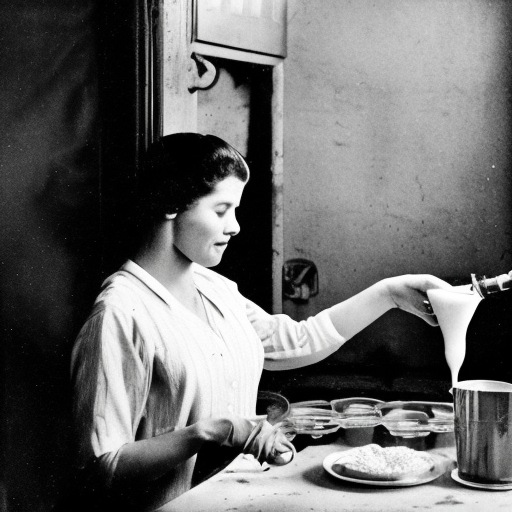

In [14]:
image

In [19]:
prompt = "Photograph of woman grabs a cereal box from the cupboard, in vintage black & white"
negative_prompt = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"
image = pipe(prompt, negative_prompt=negative_prompt).images[0]  

  0%|          | 0/50 [00:00<?, ?it/s]

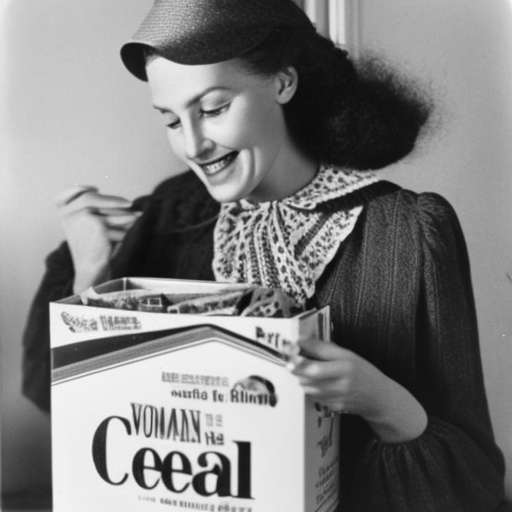

In [20]:
image

In [2]:
import numpy as np
"""
Linear interpolate between start frame and end frame

start: shape (tokens, feat_dim), text embedding of the starting frame
end: shape (tokens, feat dim), text embedding of the ending frame
num_frames: number of frames to be produced between the start and end frames

return: shape (num_frames, tokens, feat dim), embeddings of interpolated text
"""
def linear_interpolate(start, end, num_frames):
  if len(start.shape) == 2:
    start = torch.unsqueeze(start, dim=0)
  if len(end.shape) == 2:
    end = torch.unsqueeze(end, dim=0)

  steps = np.linspace(0., 1., num_frames+2)[1:-1]
  prompt_embeddings_interp = torch.zeros_like(start)
  for step in steps:
    prompt_embeddings_interp = torch.cat((prompt_embeddings_interp,(1 - step)*start + step*end), dim=0)
  prompt_embeddings_interp = prompt_embeddings_interp[1:,:,:]

  return prompt_embeddings_interp

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

num_images_per_prompt = 1
do_classifier_free_guidance = True

prompt_embeddings_start, negative_embedding = pipe._encode_prompt("start", device, num_images_per_prompt, do_classifier_free_guidance)
prompt_embeddings_end = pipe._encode_prompt("end", device, num_images_per_prompt, do_classifier_free_guidance)[1,:,:]

print(linear_interpolate(prompt_embeddings_start, prompt_embeddings_end, 5).shape)

torch.Size([5, 77, 1024])


In [21]:
scene_lists = []

scene_lists.append(["Woman enters the kitchen",
"Woman opens the refrigerator",
"Woman takes out a carton of milk",
"Woman pours milk into a glass",
"Woman grabs a cereal box from the cupboard",
"Woman pours cereal into a bowl",
"Woman sits down at the table",
"Woman eats breakfast"])

scene_lists.append(["Child picks up a paintbrush",
"Child dips the paintbrush into a jar of red paint",
"Child starts painting on a blank canvas",
"Child switches to a blue paint and adds strokes to the painting",
"Child grabs a yellow paint and adds splatters of color",
"Child steps back to assess the artwork",
"Child adds final touches with a fine brush",
"Child signs the painting in the corner"])

scene_lists.append(["Hiker straps on a backpack",
"Hiker tightens the laces of hiking boots",
"Hiker grabs a water bottle and puts it in the side pocket",
"Hiker picks up a hiking pole and adjusts the height",
"Hiker checks the trail map and compass",
"Hiker starts walking on the trail",
"Hiker enjoys the scenic views",
"Hiker takes a short break to drink water",
"Hiker continues hiking uphill",
"Hiker reaches the mountain summit and takes in the breathtaking panorama",
"Hiker captures a photo to commemorate the achievement",
"Hiker begins descending the mountain"])

scene_lists.append(["Student opens a textbook",
"Student flips through the pages to the assigned chapter",
"Student reads the introduction and takes notes",
"Student underlines key points in the text",
"Student refers to supplementary materials for further understanding",
"Student highlights important sections in different colors",
"Student takes a short break and reviews the notes",
"Student continues reading the next chapter",
"Student summarizes the main ideas in their own words",
"Student completes the chapter exercises",
"Student reviews the chapter and prepares for the upcoming test"])

scene_lists.append(["Chef gathers ingredients from the pantry",
"Chef washes and prepares the vegetables",
"Chef preheats the oven to the desired temperature",
"Chef seasons the meat with herbs and spices",
"Chef chops the vegetables into bite-sized pieces",
"Chef heats a skillet on the stovetop",
"Chef sears the meat on both sides",
"Chef sautés the vegetables in the same skillet",
"Chef transfers the meat and vegetables to a baking dish",
"Chef pours a savory sauce over the ingredients",
"Chef covers the dish with aluminum foil",
"Chef places the dish in the oven and sets the timer",
"Chef prepares a side dish to accompany the main course",
"Chef removes the dish from the oven when cooked",
"Chef garnishes the dish and plates the meal"
])

In [27]:
dataset.keys()

dict_keys(['negative_prompt', 'scripts', 'prefixes', 'suffixes'])

In [22]:
dataset = {}
dataset['negative_prompt'] = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"

dataset["scripts"] = scene_lists
dataset["prefixes"] = ["Photograph of ", "Painting of "]
dataset["suffixes"] = [", in vintage black & white", ", in high resolution color"]

In [23]:
import json

In [24]:
with open('dataset.json', 'w') as file:
    json.dumps(filedataset)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 with open('dataset.json', 'w') as file:                                                      │
│ ❱ 2 │   json.dumps(dataset, file)                                                                │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: dumps() takes 1 positional argument but 2 were given

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-base"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = dataset["prefixes"][0] + dataset["scripts"][0][0] + dataset["suffixes"][0]
negative_prompt = dataset["negative_prompt"]
image = pipe(prompt, negative_prompt).images[0]  